### 패키지 불러오기

In [2]:
import os
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# early stopping
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

데이터셋 경로 지정

In [3]:
# 데이터셋 경로 지정
train_horse_dir = './dataset/horse-or-human/train/horses'
train_human_dir = './dataset/horse-or-human/train/humans'

학습 데이터 리스트업

In [4]:
# 학습 데이터 리스트업
train_horse_names = os.listdir(train_horse_dir)
train_human_names = os.listdir(train_human_dir)

horse_files = [train_horse_dir + '/' + f for f in train_horse_names]
human_files = [train_human_dir + '/' + f for f in train_human_names]

# 학습 데이터의 개수 확인
print('horse:', len(train_horse_names))
print('human:', len(train_human_names))

horse: 1500
human: 1581


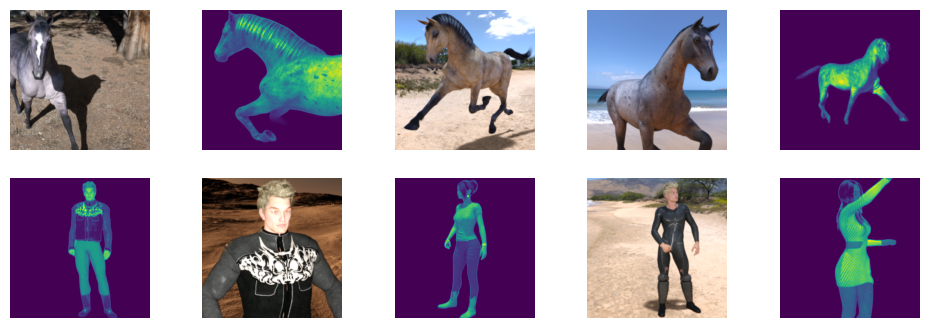

In [5]:
# 데이터 미리보기
fig, axes = plt.subplots(2,5, figsize=(12,4))
ax = np.reshape(axes, -1)

for i, path in enumerate(horse_files[:5] + human_files[:5]):
    img = plt.imread(path)
    ax[i].axis('off')
    ax[i].imshow(img)

plt.show()

### 딥러닝 모델 설계하기

In [6]:
# 모델 설계
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPool2D(2, 2),
    
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # 과적합 방지를 위한 Dropout 추가
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

/opt/anaconda3/envs/tf/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-09-05 19:19:12.293418: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-09-05 19:19:12.293458: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-09-05 19:19:12.293470: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-09-05 19:19:12.293498: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-05 19:19:12.293521: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271]

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 298, 298, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 149, 149, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 147, 147, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 73, 73, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 71, 71, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 35, 35, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 33, 33, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,606,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,704,097 (6.50 MB)

 Trainable params: 1,704,097 (6.50 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
model.compile(loss='binary_crossentropy',
            optimizer=Adam(learning_rate=0.001),
            metrics=['accuracy'])

In [8]:
# 이미지 값을 0~1 사이로 제한
train_datagen = ImageDataGenerator(rescale=1/255.)

# train set
train_generator = train_datagen.flow_from_directory(
  './dataset/horse-or-human/train/',
  target_size=(300, 300),  # 해상도 조절
  batch_size=128,  # 배치 크기
  class_mode='binary'  # 분류 방법
)

# valid set
valid_generator = train_datagen.flow_from_directory(
  './dataset/horse-or-human/validation/',
  target_size=(300, 300),
  batch_size=128,
  class_mode='binary'
)
 
# EarlyStopping 설정
es = EarlyStopping(
    monitor='val_loss',   # val_loss를 모니터링
    patience=2,           # 개선되지 않은 3번의 epoch 이후 종료
    verbose=1,            # 콘솔에 조기 종료 로그 표시
    restore_best_weights=True  # 가장 성능이 좋은 모델 가중치로 복원
)


checkpoint = ModelCheckpoint(
  filepath='./checkpoint.keras', # 모델의 임시저장 파일을 어디에 만들것인가
  verbose=2, # 로그를 보여줄지
  save_best_only=True, # 가장 best 값만 저장할 것인가
  monitor='val_loss',
  mode='auto'
)

# 클래스 비율에 따라 가중치 계산
class_weights = {0: 3162 / (3000 + 3162),  # Horse에 대한 가중치
                 1: 3000 / (3000 + 3162)}  # Human에 대한 가중치

# steps_per_epoch 설정
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size

# 모델 학습 시 class_weight 매개변수에 전달
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,  # 올바른 steps_per_epoch 값 설정
    validation_data=valid_generator,
    validation_steps=validation_steps,  # 올바른 validation_steps 값 설정
    epochs=15,
    verbose=1,
    callbacks=[checkpoint, es],
    class_weight=class_weights  # 클래스 가중치 적용
)

Found 3081 images belonging to 2 classes.
Found 768 images belonging to 2 classes.
Epoch 1/15


2024-09-05 19:19:16.551993: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
/opt/anaconda3/envs/tf/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6711 - loss: 0.3133
Epoch 1: val_loss improved from inf to 1.26683, saving model to ./checkpoint.keras


2024-09-05 19:19:51.442054: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-05 19:19:51.442371: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-09-05 19:19:51.442598: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6607868447885809124
2024-09-05 19:19:51.442608: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12390111066149174992
2024-09-05 19:19:51.442618: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15656575920215477944
/opt/anaconda3/envs/tf/lib/python3.9/contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generat

8/8 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - accuracy: 0.6762 - loss: 0.3100 - val_accuracy: 0.5312 - val_loss: 1.2668
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6772 - loss: 0.3137
Epoch 2: val_loss improved from 1.26683 to 0.42628, saving model to ./checkpoint.keras


2024-09-05 19:20:11.123505: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-05 19:20:11.123561: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-09-05 19:20:11.123777: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6607868447885809124
2024-09-05 19:20:11.123789: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12390111066149174992
2024-09-05 19:20:11.123804: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15656575920215477944


8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.6833 - loss: 0.3090 - val_accuracy: 0.8203 - val_loss: 0.4263
Epoch 3/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8785 - loss: 0.1758
Epoch 3: val_loss improved from 0.42628 to 0.38443, saving model to ./checkpoint.keras


2024-09-05 19:20:29.964558: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-05 19:20:29.964596: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-09-05 19:20:29.965302: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6607868447885809124
2024-09-05 19:20:29.965314: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12390111066149174992
2024-09-05 19:20:29.965328: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15656575920215477944


8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.8790 - loss: 0.1749 - val_accuracy: 0.8503 - val_loss: 0.3844
Epoch 4/15
1/8 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.9062 - loss: 0.1472

2024-09-05 19:20:31.841622: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-05 19:20:31.841676: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/Add_12/_48]]
2024-09-05 19:20:31.841709: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 4205741172985012391
2024-09-05 19:20:31.841720: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 13957045531289219096
2024-09-05 19:20:31.841743: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14228087217092608323
2024-09-05 19:20:31.841756: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 25142328


Epoch 4: val_loss improved from 0.38443 to 0.38273, saving model to ./checkpoint.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 469ms/step - accuracy: 0.9062 - loss: 0.1472 - val_accuracy: 0.8503 - val_loss: 0.3827
Epoch 5/15


2024-09-05 19:20:35.011006: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-05 19:20:35.011030: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-09-05 19:20:35.011040: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6607868447885809124
2024-09-05 19:20:35.011046: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12390111066149174992
2024-09-05 19:20:35.011055: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15656575920215477944


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8909 - loss: 0.1344
Epoch 5: val_loss did not improve from 0.38273
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.8913 - loss: 0.1335 - val_accuracy: 0.8529 - val_loss: 0.5188
Epoch 6/15


2024-09-05 19:20:54.836536: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-05 19:20:54.836572: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-09-05 19:20:54.836816: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6607868447885809124
2024-09-05 19:20:54.836829: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12390111066149174992
2024-09-05 19:20:54.836841: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15656575920215477944


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9112 - loss: 0.1085
Epoch 6: val_loss did not improve from 0.38273
8/8 ━━━━━━━━━━━━━━━━━━━━ 32s 4s/step - accuracy: 0.9115 - loss: 0.1085 - val_accuracy: 0.8685 - val_loss: 0.3855


2024-09-05 19:21:27.112621: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-05 19:21:27.113342: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-09-05 19:21:27.113545: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6607868447885809124
2024-09-05 19:21:27.113553: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12390111066149174992
2024-09-05 19:21:27.113563: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15656575920215477944


Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 4.


모델 평가

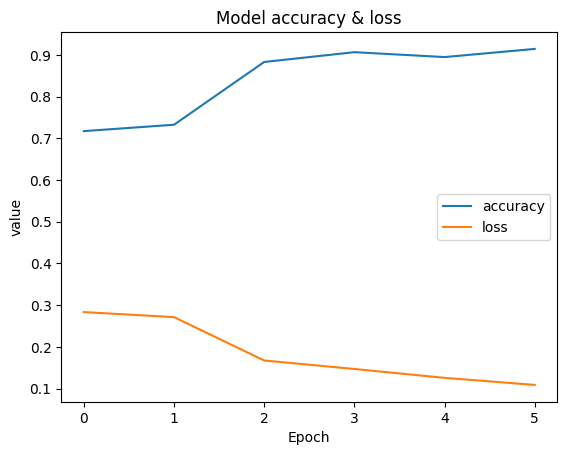

In [9]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('Model accuracy & loss')
plt.xlabel('Epoch')
plt.ylabel('value')
plt.legend(['accuracy', 'loss'], loc='center right')
plt.show()

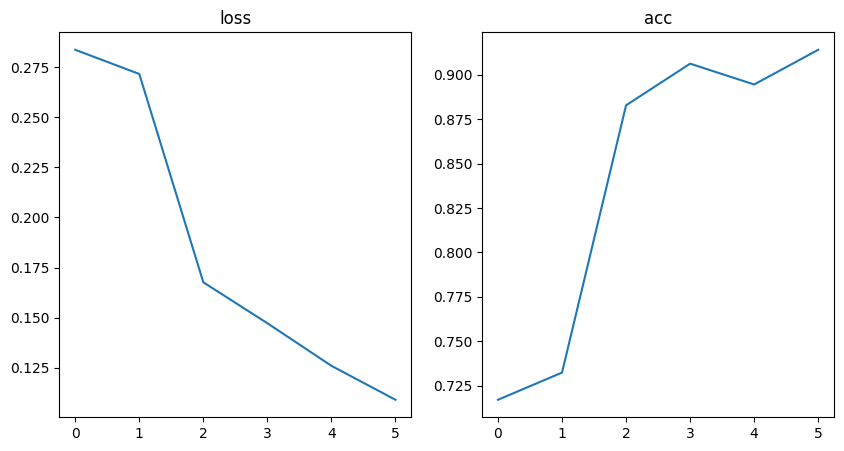

In [10]:
#loss, acc 현황을 그래프로 확인
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.title("loss")
plt.subplot(1, 2, 2)
plt.title("acc")
plt.plot(history.history['accuracy'])
plt.show()

모델 검증

In [11]:
# 모델 검증
results = model.evaluate(valid_generator)
print("test loss, test acc:", results)

6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 724ms/step - accuracy: 0.8424 - loss: 0.4047
test loss, test acc: [0.38272789120674133, 0.8502604365348816]


외부 데이터 테스트

In [12]:
# 이미지 전처리
dlist = './dataset/horse-or-human/test/'
predict_list = os.listdir(dlist)
print(predict_list)

img = [cv2.imread(dlist + i) for i in predict_list]
img = [cv2.resize(i, (300,300)) for i in img]
img = np.array(img)
img = img.astype('float32') / 255.0

# 분류
cutoff = .5
predictions = model.predict(img)
print(predictions >= cutoff)

['horse2.webp', 'human1.jpg', 'human2.jpg', 'horse3.jpg', 'horse1.jpg']
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[[False]
 [False]
 [ True]
 [ True]
 [False]]


In [13]:
model.save('./model.keras')

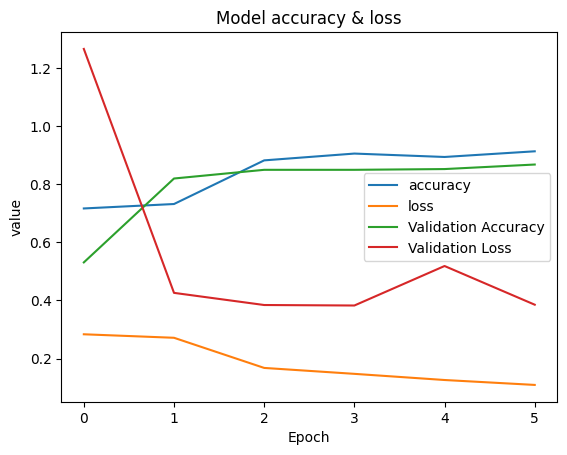

In [14]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["loss"])
plt.plot(history.history["val_accuracy"])
plt.plot(history.history["val_loss"])

plt.title("Model accuracy & loss")
plt.xlabel("Epoch")
plt.ylabel("value")
plt.legend(
    ["accuracy", "loss", "Validation Accuracy", "Validation Loss"], loc="center right"
)
plt.show()